<a href="https://colab.research.google.com/github/cristinarainich/MLTSA22_KRainich/blob/main/practice/HW1_traintest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


In [2]:
# importing data
grbAG = pd.read_csv('https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/main/HW1/grb050525A.csv')
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [3]:
# create the log-time variable
grbAG["logtime"] = np.log10(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


In [4]:
grbAG.columns

Index(['filter', 'time', 'mag', 'magerr', 'upperlimit', 'logtime'], dtype='object')

In [5]:
grbAG['filter'].value_counts()

V     44
U     16
B     16
M2    15
W1    15
W2    13
Name: filter, dtype: int64

Text(0.5, 0, 'log time (sec after explosion)')

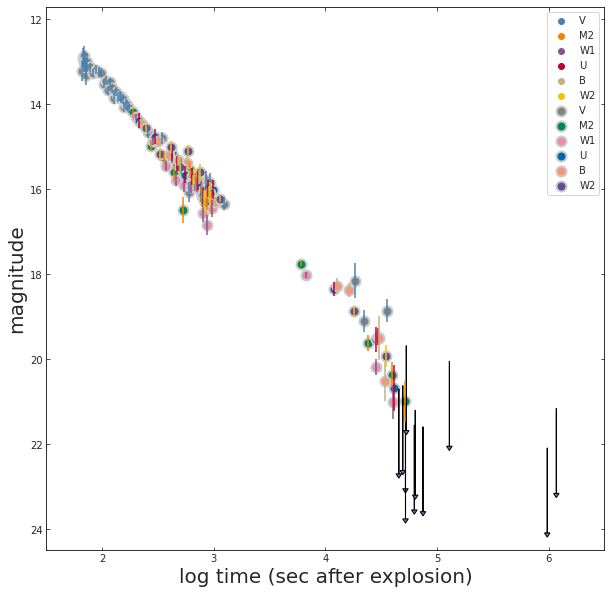

In [8]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
line_name = []
for f in grbAG['filter'].unique():
  pl.errorbar(x = grbAG.loc[grbAG['filter'] == f, 'logtime'], 
              y = grbAG.loc[grbAG['filter'] == f, 'mag'], 
              yerr = grbAG.loc[grbAG['filter'] == f, 'magerr'], ls = '')
  pl.scatter(x = grbAG.loc[grbAG['filter'] == f, 'logtime'],
             y = grbAG.loc[grbAG['filter'] == f, 'mag'], label = f)

for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')
    
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

pl.xlim(1.5, 6.5)
pl.ylim(24.5,11.7)          
pl.legend()

pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

In [9]:
grbAG_wout_upper = grbAG[grbAG.upperlimit == 0] 
#new dataframe without upper limits, as in the last step the original df would be necessary for the plot

In [10]:
x = grbAG_wout_upper['logtime']
X = np.c_[np.ones((len(grbAG_wout_upper), 1)), x]
y = grbAG_wout_upper['mag']
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)

shape of the input array X (108, 2)
shape of the input array y (108,)


In [11]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


In [12]:
lr = LinearRegression()
lr.fit(X, y)
print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


In [13]:
# L1 with abs
def line(x, intercept, slope):
  return slope * x + intercept

def l1(args, x, y):
  a, b = args
  return sum(np.abs(line(x, b, a) - y))

initialGuess = (10, 1)
l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

      fun: 26.30369174968314
 hess_inv: array([[ 0.00013497, -0.00028283],
       [-0.00028283,  0.00137989]])
      jac: array([0.49647164, 0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 586
      nit: 12
     njev: 142
   status: 2
  success: False
        x: array([2.6405645, 8.2261225])

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


In [15]:
# chi excluding upper limits
def chi2(args, x, y, s):
  a, b = args
  return sum((line(x, b, a) - y)**2 / s **2)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values
initialGuess = (10, 1)
chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 317.42066980130545
 hess_inv: array([[ 0.00019852, -0.0005341 ],
       [-0.0005341 ,  0.00153434]])
      jac: array([ 4.19616699e-05, -7.62939453e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 135
      nit: 6
     njev: 31
   status: 2
  success: False
        x: array([2.48019102, 8.59948746])

best fit parameters from the minimization of the chi squared: slope 2.48, intercept 8.60


In [16]:
x_train, x_test, y_train, y_test, s_train, s_test = x[:75], x[75:], y[:75], y[75:], s[:75], s[75:]

In [17]:
def Rsquare(args, x, y):
    a, b = args
    return 1 - (1 / x.shape[0]) * sum((y - line(x, a, b))**2) / np.std(y)**2

In [20]:
def plotline(pars, x, color='k', symbol='-', label='model', ax=ax):
    slope, intercept = pars
    y = line(x, intercept, slope)
    ax.plot(x, y, ls=symbol, c=color, label=label)

def plotdatapoints(x_train, y_train, s_train, x_test, y_test, s_test, linepars=None):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
  #Use pl.errorbar to plot the uncertainties

  pl.errorbar(x_train, y_train, s_train, fmt='.', ms=0,
                fcolor=None, label=None, color='SteelBlue')
    
  pl.errorbar(x_test, y_test, s_test, fmt='.', ms=0,
                fcolor=None, label=None, color='IndianRed')

  pl.scatter(x_train, y_train,  
             s=100, alpha=1, linewidth=2, 
             label="training", color='SteelBlue')

  pl.scatter(x_test, y_test,
            alpha=1, s=100, linewidth=2,
           label="testing", color='IndianRed')    

  if not linepars is None:
    plotline(linepars[:2], linepars[2], ax=ax, label=linepars[3])
    

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)          
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time (sec after explosion)", fontsize=20);
  return ax

In [21]:
import sklearn
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
     x, y, s, test_size=0.25, random_state=42)

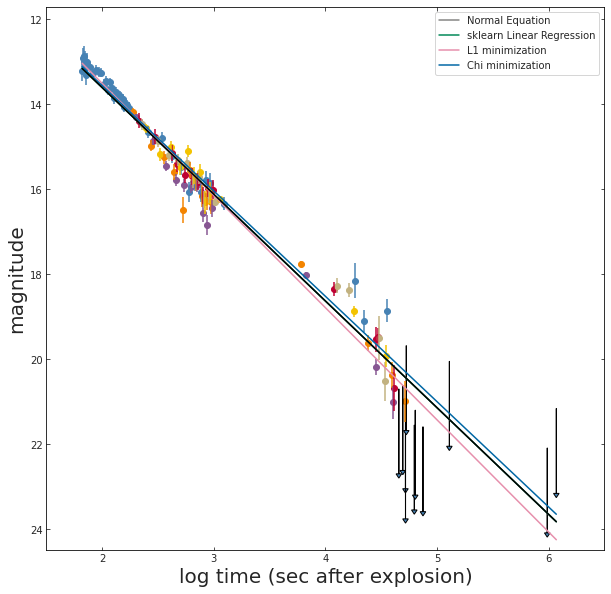

In [ ]:
def plotline(a, b, modelname):
  ax.plot(grbAG['logtime'], a + b * grbAG['logtime'], label = modelname)


ax = pl.figure(figsize=(10,10)).add_subplot(111)
for f in grbAG['filter'].unique():
  pl.errorbar(x = grbAG.loc[grbAG['filter'] == f, 'logtime'], 
              y = grbAG.loc[grbAG['filter'] == f, 'mag'], 
              yerr = grbAG.loc[grbAG['filter'] == f, 'magerr'], ls = '')
  pl.scatter(x = grbAG.loc[grbAG['filter'] == f, 'logtime'],
             y = grbAG.loc[grbAG['filter'] == f, 'mag'])

for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

#normal equation
plotline(theta_best[0], theta_best[1], 'Normal Equation')
         
#sklearn
plotline(lr.intercept_, lr.coef_[1], 'sklearn Linear Regression')
         
#minimize L1
plotline(l1Solution.x[1], l1Solution.x[0], 'L1 minimization')
         
#minimize chi2
plotline(chi2Solution.x[1], chi2Solution.x[0], 'Chi minimization')

pl.legend()

pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.